# Titanic 

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import random
import numpy as np
import pandas as pd
from sklearn import datasets, svm, tree, preprocessing, metrics
from sklearn.model_selection import train_test_split
import sklearn.ensemble as ske
import os

In [2]:
# The lesson is adapted from a Kaggle competition.

## Load the data from the Kaggle competition.

In [3]:
titanic_df = pd.read_csv(os.path.normpath('../Data/titanic3.csv'))
# This data represents almost 80% of the passengers.
# The crew is not included.
titanic_df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,0.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,0.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


## Explore the Data

In [4]:
titanic_df.shape

(1310, 14)

In [5]:
# 1310 passengers
# 14 columns

In [6]:
# The column heading variables have the following meanings:

# pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
# survived - Survival (0 = No; 1 = Yes)
# name - Name
# sex - Sex
# age - Age
# sibsp - Number of Siblings/Spouses Aboard
# parch - Number of Parents/Children Aboard
# ticket - Ticket Number
# fare - Passenger Fare in pre-1970 British Pounds
# cabin - Cabin
# embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
# boat - Lifeboat number (if survived)
# body - Body number (if did not survive and body was recovered)
# home.dest - Home and destination

In [7]:
# Average chance of survival
print("Average chance of surviving: {0:4.1f}%".format(100*titanic_df['survived'].mean()))

Average chance of surviving: 38.2%


In [8]:
# Social classes were heavily stratified in the early 20th, and this was especially true 
# on the Titanic where the luxurious 1st class areas were completely off limits to the 
# middle-class passengers of 2nd class, and especially to those who carried a 3rd class
# “economy price” ticket. To get a view into the composition of each class, we can group 
# data by class, and view the averages for each column:

In [9]:
titanic_df.groupby('pclass').mean().round(3)

,survived,age,sibsp,parch,fare,body
pclass,,,,,,
1.0,0.619,39.160,0.437,0.365,87.509,162.829
2.0,0.430,29.507,0.394,0.368,21.179,167.387
3.0,0.255,24.816,0.568,0.401,13.303,155.818


In [10]:
# We can start drawing some interesting insights from this data. For instance, passengers
# in 1st class had a 62% chance of survival, compared to a 25.5% chance for those in 3rd 
# class. Additionally, the lower classes generally consisted of younger people, and the
# ticket prices for first class were predictably much higher than those for second and 
# third class. The average ticket price for first class, £87.5, is equivalent to $13,487 
# in 2016.

In [11]:
# We can extend our statistical breakdown using the grouping function for both class and sex:

In [12]:
class_sex_grouping = titanic_df.groupby(['pclass','sex']).mean().round(3)
class_sex_grouping

survived     age  sibsp  parch     fare     body
pclass sex                                                     
1.0    female     0.965  37.038  0.556  0.472  109.412      NaN
       male       0.341  41.029  0.341  0.279   69.888  162.829
2.0    female     0.887  27.499  0.500  0.651   23.235   52.000
       male       0.146  30.815  0.327  0.193   19.905  171.233
3.0    female     0.491  22.185  0.792  0.731   15.324  183.000
       male       0.152  25.962  0.471  0.256   12.415  151.854

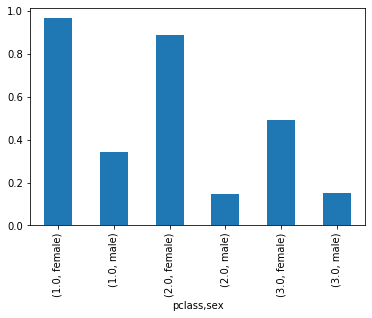

In [13]:
class_sex_grouping['survived'].plot.bar()

In [14]:
# While the Titanic was sinking, the officers famously prioritized who was allowed 
# in a lifeboat with the strict maritime tradition of evacuating women and children 
# first. 
# Our statistical results clearly reflect the first part of this policy, as across 
# all classes women were much more likely to survive than the men. We can also see 
# that the women were younger than the men on average, were more likely to be travel.

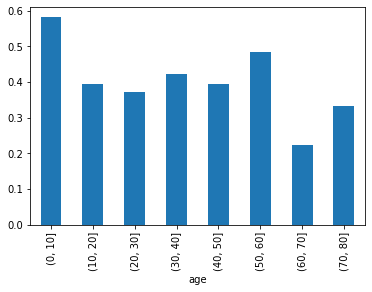

In [15]:
# The effectiveness of the second part of this “Women and children first” policy 
# can be deduced by breaking down the survival rate by age.
group_by_age = pd.cut(titanic_df["age"], np.arange(0, 90, 10))
age_grouping = titanic_df.groupby(group_by_age).mean()
age_grouping['survived'].plot.bar()

In [16]:
# We can see that children had the higher chance of surviving but not a great chance!

## Preparing The Data for Machine Learning

In [17]:
# Before we can feed our dataset into a machine learning algorithm, we have to remove missing
# values and split it into training and test sets.

# If we perform a count of each column, we will see that much of the data on certain fields is 
# missing. Most machine learning algorithms will have a difficult time handling missing values, 
# so we will need to make sure that each row has a value for each column.

In [18]:
titanic_df.count()

pclass       1309
survived     1309
name         1309
sex          1309
age          1046
sibsp        1309
parch        1309
ticket       1309
fare         1308
cabin         295
embarked     1307
boat          486
body          121
home.dest     745
dtype: int64

In [19]:
# Most of the rows are missing values for “boat” and “cabin”, so we will remove these 
# columns from the data frame. A large number of rows are also missing the “home.dest” 
# field; here we fill the missing values with “NA”. A significant number rows are also 
# missing an age value. We have seen above that age could have a significant effect on 
# survival chances, so we will have to drop all of rows that are missing an age value.
# When we run the count command again we can see that all remaining columns now contain
# the same number of values.

titanic_df = titanic_df.drop(['body','cabin','boat'], axis=1)
titanic_df["home.dest"] = titanic_df["home.dest"].fillna("NA")
titanic_df = titanic_df.dropna()
titanic_df.count()

pclass       1043
survived     1043
name         1043
sex          1043
age          1043
sibsp        1043
parch        1043
ticket       1043
fare         1043
embarked     1043
home.dest    1043
dtype: int64

In [20]:
# Now we need to format the remaining data in a way that our machine learning algorithms will accept.

In [21]:
# The “sex” and “embarked” fields are both string values that correspond to categories(i.e “Male”
# and “Female”) so we will run each through a preprocessor. This preprocessor will convert these 
# strings into integer keys, making it easier for the classification algorithms to find patterns.
# For instance, “Male” and “Female” will be converted to 0 and 1 respectively. The “name”, “ticket”, 
# and “home.dest” columns consist of non-categorical string values, and as such are difficult to
# use in a classification algorithm, so we will drop them from the dataset.

def preprocess_titanic_df(df):
    processed_df = df.copy()
    le = preprocessing.LabelEncoder()
    processed_df.sex = le.fit_transform(processed_df.sex)
    processed_df.embarked = le.fit_transform(processed_df.embarked)
    processed_df = processed_df.drop(['name','ticket','home.dest'],axis=1)
    return processed_df

processed_df = preprocess_titanic_df(titanic_df)

In [22]:
X = processed_df.drop(['survived'], axis=1).values

In [23]:
y = processed_df['survived'].values

In [24]:
X

array([[  1.    ,   0.    ,  29.    , ...,   0.    , 211.3375,   2.    ],
       [  1.    ,   1.    ,   0.9167, ...,   2.    , 151.55  ,   2.    ],
       [  1.    ,   0.    ,   2.    , ...,   2.    , 151.55  ,   2.    ],
       ...,
       [  3.    ,   1.    ,  26.5   , ...,   0.    ,   7.225 ,   0.    ],
       [  3.    ,   1.    ,  27.    , ...,   0.    ,   7.225 ,   0.    ],
       [  3.    ,   1.    ,  29.    , ...,   0.    ,   7.875 ,   2.    ]])

In [25]:
y

array([1., 1., 0., ..., 0., 0., 0.])

In [26]:
# Next we separate the dataset into two arrays, “X” containing all of the values for each row besides
# “survived”, and “y” containing only the “survived” value for that row. The classification algorithms 
# will compare the attribute values of “X” to the corresponding values of “y” in order to detect 
# patterns in how different attributes values tend to affect the survival of a passenger.

# Finally we break the “X” and “y” array into two parts each - a training set and a testing set. 
# We will feed the training set into the classification algorithm in order to form a trained model. 
# Once the model is formed, we will use it to classify the testing set, allowing us to determine
# the accuracy of the model. Here we have have made a 20/80 split, such that 80% of the dataset 
# will be used for training and 20% will be used for testing.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [28]:
# Classification - The Fun Part

# We will start off with a simple decision tree classifier. A decision tree examines one variable 
# at a time, and splits into one of two branches based on the result of that value, at which point
# it does the same for the next variable. 

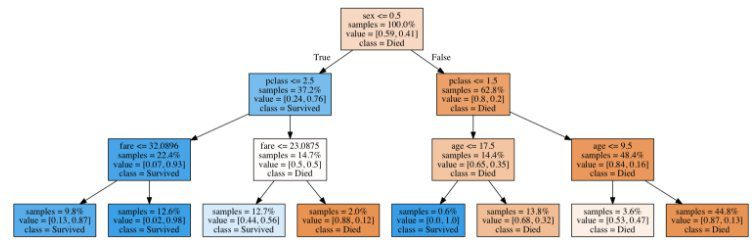

In [29]:
clf_dt = tree.DecisionTreeClassifier(max_depth=10)

In [30]:
clf_dt.fit (X_train, y_train)
clf_dt.score (X_test, y_test)

0.7799043062200957

In [31]:
from sklearn.model_selection import ShuffleSplit
#shuffle_validator = ShuffleSplit(len(X), n_iter=20, test_size=0.2, random_state=0)
shuffle_validator = ShuffleSplit(n_splits=20, test_size=.25, random_state=0)

from sklearn.model_selection import cross_val_score
def test_classifier(clf):
    scores = cross_val_score(clf, X, y, cv=shuffle_validator)
    print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std()))

test_classifier(clf_dt)

Accuracy: 0.7709 (+/- 0.02)


In [32]:
# Let's compare the results to some other classifiers

clf_rf = ske.RandomForestClassifier(n_estimators=50)
test_classifier(clf_rf)

# Accuracy: 0.7837 (+/- 0.02)

clf_gb = ske.GradientBoostingClassifier(n_estimators=50)
test_classifier(clf_gb)

# Accuracy: 0.8201 (+/- 0.02)

eclf = ske.VotingClassifier([('dt', clf_dt), ('rf', clf_rf), ('gb', clf_gb)])
test_classifier(eclf)


Accuracy: 0.7837 (+/- 0.02)
Accuracy: 0.8132 (+/- 0.02)
Accuracy: 0.8044 (+/- 0.02)


In [33]:
# Class assignment 1

# Choose 3 other classifiers from Scikit-learn and compare results.

In [34]:
# Class assignment 2

# Using the SKlearn documentation, tune the hyperparameters to optimize accuracy.